This notebook is structured as:
- Showing that WLS is not the correct approach even with idealized data

In [14]:
%matplotlib inline 

In [146]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from scipy import odr

## Setup

Below is a simulation where we have 
$$\mu_y(e) = \alpha_0 + \alpha_1 \mu_x(e)$$
where $e$ stands for different experiments. Let's pretend we only have $k$ measurement (configurations) per experiment but we have:
where
$$\binom{x_i(e)}{y_i(e)} \sim MVN\left(\binom{\mu_x(e)}{\mu_y(e)}, \underbrace{\begin{bmatrix} \sigma^2_x & 0 \\ 0 & \sigma^2_y \end{bmatrix}}_{=\Sigma}\right)$$

In [269]:
num_e = 20
num_config = 100

In [270]:
e_range = np.linspace(0, 100, num_e)

#### Define the data generation process

First define the truth we want to recover with data

In [271]:
alpha0 = 1
alpha1 = 2
def mu_x(e_i):
    return e_i
def mu_y(mu_x):
    return alpha1 * mu_x + alpha0

In [272]:
mu_xs = [mu_x(e_i) for e_i in e_range]
mu_ys = [mu_y(mu_xi) for mu_xi in mu_xs]

In [273]:
noise_sigma = 10

Our data is generated as a contaminated version of the truth

In [274]:
x = np.stack([np.random.normal(mu_xi, noise_sigma, num_config)
              for mu_xi in mu_xs])
y = np.stack([np.random.normal(mu_yi, noise_sigma, num_config)
              for mu_yi in mu_ys])

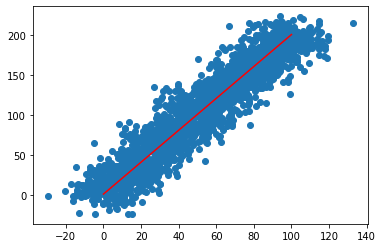

In [275]:
plt.scatter(x.reshape(-1), y.reshape(-1))
plt.plot(mu_xs, mu_ys, color='red')

Define how data is related to the truth, the usual assumption is that data is an unbiased measurement of the truth

#### It's common to use linear regression to estimate the line

In [276]:
num_sim = 1000
coeffs = []
for i in range(num_sim):
    sim_x = np.concatenate(
        [np.random.normal(mu_xi, noise_sigma, num_config)
         for mu_xi in mu_xs])
    sim_y = np.concatenate(
        [np.random.normal(mu_yi, noise_sigma, num_config)
         for mu_yi in mu_ys])
    ols = sm.OLS(sim_y, sm.add_constant(sim_x)).fit()
    coeffs.append(ols.params)

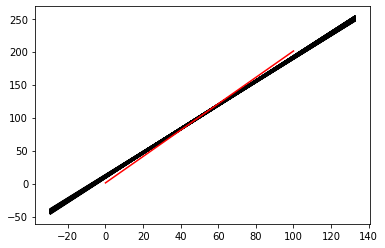

In [277]:
poss_x = np.linspace(np.min(x), np.max(x), 100)
for i in range(num_sim):
    plt.plot(poss_x,
             coeffs[i][0] + coeffs[i][1] * poss_x,
             color='black')
    
plt.plot(mu_xs, mu_ys, color='red')

In [278]:
coeffs_mat = np.stack(coeffs)

In [279]:
np.apply_along_axis(np.mean, 0, coeffs_mat)

array([10.76178876,  1.80468821])

Recall that the true values, we want to estimate are:

In [280]:
np.array([alpha0, alpha1])

array([1, 2])

#### Is it bias or variance?

In [281]:
np.apply_along_axis(np.std, 0, coeffs_mat)

array([0.83376134, 0.01372288])

answer: Definitely bias given the small-ish standard deviatiosn.

#### What to do? Orthogonal Regression

In [282]:
def linear_fun(alpha_hat, x):
    return alpha_hat[0] + alpha_hat[1] * x

lin_mod = odr.Model(linear_fun)

In [283]:
coeffs = []
for i in range(num_sim):
    sim_x = np.stack(
        [np.random.normal(mu_xi, noise_sigma, num_config)
         for mu_xi in mu_xs])
    sim_y = np.stack(
        [np.random.normal(mu_yi, noise_sigma, num_config)
         for mu_yi in mu_ys])
    sx = np.mean(np.apply_along_axis(np.std, 1, sim_x))
    sy = np.mean(np.apply_along_axis(np.std, 1, sim_y))
    sim_x_flat = sim_x.reshape(-1)
    sim_y_flat = sim_y.reshape(-1)
    mydata = odr.RealData(sim_x_flat, sim_y_flat, sx=sx, sy=sy)
    # starting values
    ols = sm.OLS(sim_y_flat,
                 sm.add_constant(sim_x_flat)).fit()
    myodr = odr.ODR(mydata, lin_mod, beta0=ols.params).run()
    coeffs.append(myodr.beta)

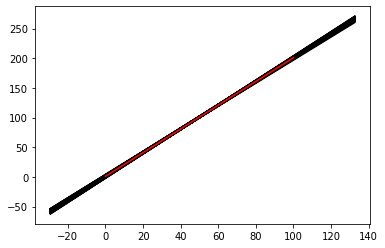

In [284]:
for i in range(num_sim):
    plt.plot(poss_x,
             coeffs[i][0] + coeffs[i][1] * poss_x,
             color='black')
    
plt.plot(mu_xs, mu_ys, color='red')

#### Something closer to the actual data

First, simulate data that looks remotely similar to the output data.
There are 2 relationships that I noticed:
- The linear line you're trying to fit between $X$ and $Y$
- The strongly relationship between hollow dots.

I was told that:
- The monte carlo samples are recycles across experiments

To emulate that pattern, I've setup the simulation as follows:
- $\epsilon \stackrel{i.i.d.}{\sim} N(0, \sigma^2)$
- $X_{(e, i)} = f_x(e) + g_e(\epsilon_i)$
- $Y_{(e, i)} = \beta_0 + \beta_1 * f_x(e) + h_e(\epsilon_i)$

We wish to recover $\beta_0$ and $\beta_1$

We have to assume that
- $E(g_e(\epsilon_i)) = 0$
- $E(h_e(\epsilon_i)) = 0$

In [456]:
num_e = 8
experiments = np.linspace(-0.005, 0.04, num_e)

In [457]:
betas = [1, 2]

In [458]:
# One set of configurations
num_config = 100
sigma = 0.0005
eps = np.random.normal(0, sigma, num_config)

In [459]:
sigma = 0.0005

def f_x(e):
    return e

def g(e, eps):
    return (1 + e) * eps

def h(e, eps):
    return 1e6 * (0.01 + e) * (eps)**2 * np.sign(eps)

x = np.stack([f_x(e_i) + g(e_i, eps) for e_i in experiments])
y = np.stack([betas[0] + f_x(e_i) * betas[1] + h(e_i, eps)
              for e_i in experiments])

In [498]:
x_avg = np.apply_along_axis(np.mean, 1, x)
y_avg = np.apply_along_axis(np.mean, 1, y)

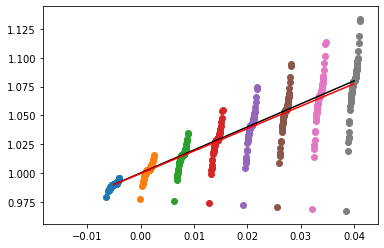

In [500]:
for i in range(len(experiments)):
    plt.scatter(x[i, :], y[i, :])

plt.plot(f_x(experiments), alphas[0] + alphas[1] * experiments, color="black")
plt.plot(x_avg, y_avg, color="red")

#### Naive Weighted Least Squares Approach

In [462]:
num_sim = 1000
coeffs = []
for i in range(num_sim):
    sim_eps = np.random.normal(0, 0.0005, num_config)
    sim_x = np.stack([f_x(e_i) + g(e_i, sim_eps) for e_i in experiments])
    sim_y = np.stack([betas[0] + f_x(e_i) * betas[1] + h(e_i, sim_eps)
              for e_i in experiments])
    sim_sy = np.apply_along_axis(np.std, 1, sim_y)
    sim_x_avg = np.apply_along_axis(np.mean, 1, sim_x)
    sim_y_avg = np.apply_along_axis(np.mean, 1, sim_y)
    sim_wls = sm.WLS(sim_y_avg, sm.add_constant(sim_x_avg),
                     weights=1/sim_sy).fit()
    coeffs.append(wls.params)

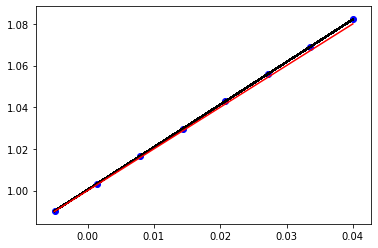

In [501]:
for i in range(num_sim):
    plt.plot(f_x(experiments),
             coeffs[i][0] + coeffs[i][1] * f_x(experiments),
             color="black")

plt.plot(f_x(experiments),
         alphas[0] + alphas[1] * f_x(experiments),
         color="red")
# The last run's average
plt.scatter(sim_x_avg,
            sim_y_avg,
            color="blue")

- The correlation between X and Y for each experiment is so strong that Y is basically known given X, this means that X and Y do not really have different sources of uncertainty. 

I believe we should try to estimate the relationship for each experiment 

In [496]:
ols_es = []
for i in range(num_e):
    covariates = np.stack([np.power(x[i, :], j) for j in range(4)], axis=-1)
    ols = sm.OLS(y[i, :].reshape(-1, 1), covariates).fit()
    ols_es.append(ols.params)

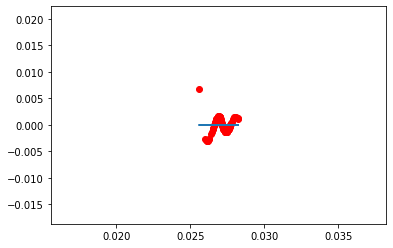

In [495]:
i = 5
covariates = np.stack([np.power(x[i, :], j) for j in range(4)], axis=-1)
plt.scatter(x[i, :], y[i, :] - np.matmul(covariates, ols_es[i]), color="red")
plt.plot(x[i, :], np.zeros(x.shape[1]))

The fit isn't perfect but it's pretty good. So

$\bar{X}_e = \frac{1}{n}\sum_i X_{(e, i)}$

$$\begin{bmatrix} \bar{X}_{e_1} \\ \vdots \\ \bar{X}_{e_k}\end{bmatrix} \to MVN\left(\begin{bmatrix} f_x(e_1) \\ \vdots \\ f_x(e_k)  \end{bmatrix}, \Sigma_f \right)$$